In [1]:
from madigan.environments import make_env
from madigan.utils.preprocessor import StackerDiscrete, StackerDiscretePairs
from madigan.utils.config import make_config

import numpy as np
import matplotlib.pyplot as plt

In [2]:
config_sine = make_config("sineComp", assets=["sineC1"],
                          data_source_type="SineAdder",
                          data_source_config={
                            'freq':[2.2, 4.1, 1., 3.],
                            'mu':[.6, 0.3, 2., 4.2],
                            'amp':[.5, 0.2, 0.4, 1.2],
                            'phase':[0., 1., 4., 0.],
                            'dX':0.01,
                            "noise": 0.0},
                         )
env_sine = make_env(config_sine)


In [3]:
config_ou = make_config("OU", assets=["ou1"],
                        data_source_type="OU",
                        data_source_config=dict(
                            mean=[10., 5., 1.],
                            theta=[.08, .15, .15],
                            phi = [.04, .04, .04])
                        )
env_ou = make_env(config_ou)

In [4]:
config_ou_pair = make_config("OUPair",
                            data_source_type="OUPair",
                            data_source_config=dict(
                                theta=.15,
                                phi = .04,
                            noise = .03)
                            )
env_ou_pair = make_env(config_ou_pair)

In [5]:
env_sine.assets , env_ou.assets, env_ou_pair.assets

([multi_sine], [OU_0, OU_1, OU_2], [OUPair_0, OUPair_1])

In [6]:
window_sine = StackerDiscrete(128, env_sine.nAssets)
window_ou = StackerDiscrete(128, norm=False, n_features=env_ou.nAssets) 
window_ou_pair1 = StackerDiscrete(128, norm=False, n_features=env_ou_pair.nAssets) 
window_ou_pair2 = StackerDiscretePairs(128, norm=False, n_feats=env_ou_pair.nAssets) 
window_ou_pair3 = StackerDiscretePairs(128, norm=True, norm_type='standard_normal', n_feats=env_ou_pair.nAssets) 

In [7]:
env_sine.reset()
env_ou.reset()
env_ou_pair.reset()

Text(0.5, 1.0, 'OU Pair Pair Stacker Std Norm')

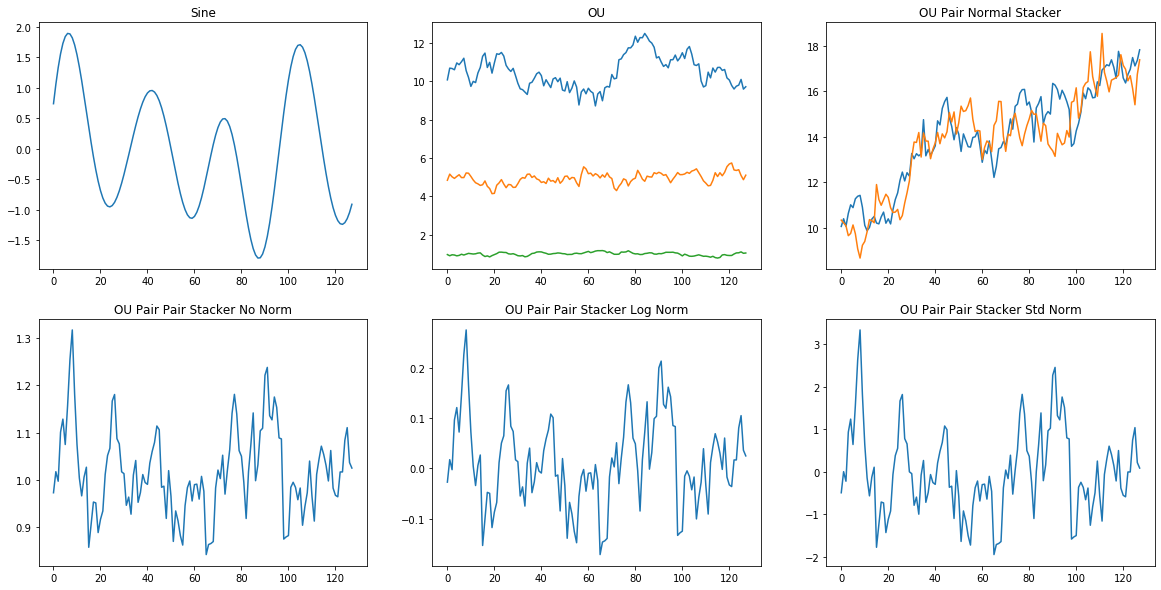

In [8]:
for i in range(128):
    window_sine.stream(env_sine.step())
    window_ou.stream(env_ou.step())
    pair_data = env_ou_pair.step()
    window_ou_pair1.stream(pair_data)
    window_ou_pair2.stream(pair_data)
    window_ou_pair3.stream(pair_data)
# while env_ou_pair.step()[0].price[0] != np.nan:
#     window_sine.stream(env_ou_pair.step())

fig, axes = plt.subplots(2,3, figsize=(20, 10))
ax = axes.flatten()
ax[0].plot(window_sine.current_data().price, label='sine')
ax[0].set_title('Sine')
ax[1].plot(window_ou.current_data().price, label='ou')
ax[1].set_title('OU')
ax[2].plot(window_ou_pair1.current_data().price)
ax[2].set_title('OU Pair Normal Stacker')
ax[3].plot(window_ou_pair2.current_data().price)
ax[3].set_title('OU Pair Pair Stacker No Norm')
ax[4].plot(np.log(window_ou_pair2.current_data().price))
ax[4].set_title('OU Pair Pair Stacker Log Norm')
ax[5].plot(window_ou_pair3.current_data().price)
ax[5].set_title('OU Pair Pair Stacker Std Norm')

In [9]:
import random
import math
random.gauss(0, 1.)

-0.3738076634173586

In [14]:
def geom_walk(noise, start):
    x = start
    dt = .01
    while True:
        x +=  x*random.gauss(0, noise)
        yield x


def geom_walk_1(noise, start):
    x = start
    while True:
        try:
            x += math.log(x if (x-1) > .001 else 1.01)*random.gauss(0, noise)
        except ValueError:
            print(x)
        yield x

        
def geom_walk_2(noise, start, dt=1.):
    x = start
    while True:
        x *= math.exp(x * - (noise**2 / 2)*dt + noise*random.gauss(0, math.sqrt(dt)))
        yield x    
        
        
def geom_walk_3(noise, start):
    x = start
    while True:
        try:
            x += math.sqrt(x if (x-1) > .001 else 1.01)*random.gauss(0, noise)
        except ValueError:
            print(x)
        yield x

In [113]:
source  = iter(geom_walk(.01, 5))
source1 = iter(geom_walk_1(.01, 1))
source2 = iter(geom_walk_2(.01, 1))
source3 = iter(geom_walk_3(.01, 1))
sources = (source, source1, source2, source3)

In [116]:
outs = [[] for i in sources]
for i in range(100000):
    for j, source in enumerate(sources):
        outs[j].append(next(source))
    

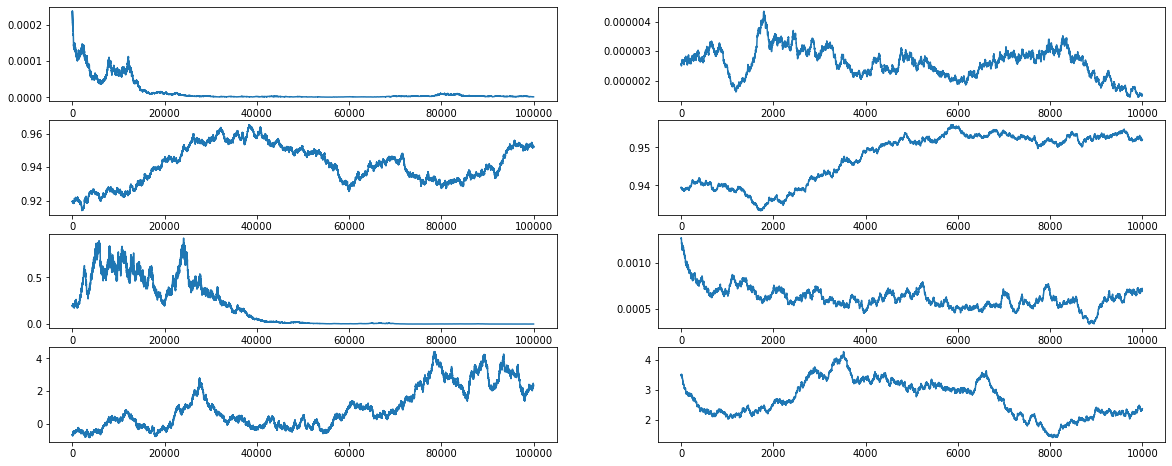

In [117]:
fig, ax = plt.subplots(len(outs),2, figsize=(20, 8))
for i, out in enumerate(outs):
    ax[i, 0].plot(out[:])
    ax[i, 1].plot(out[-10000:])

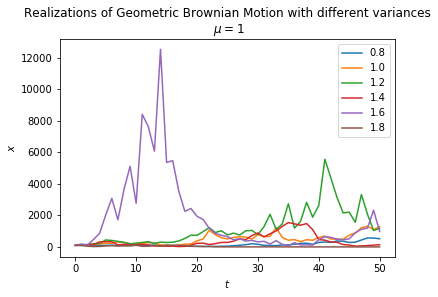

In [18]:
mu = 1
n = 50
dt = 0.1
x0 = 100
# np.random.seed(1)

sigma = np.arange(0.8, 2, 0.2)

x = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T
)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()
